In [ ]:
#datasets from:
#https://www.kaggle.com/datasets/moltean/fruits

## Library load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Portofolio/fruit_quant_aware

/content/drive/MyDrive/Portofolio/fruit_quant_aware


In [ ]:
!ls

'Copy of custom_cnn3.ipynb'  'Copy of weight_clustering.ipynb'	 Validation
'Copy of mobilenet.ipynb'     Test
'Copy of pruning.ipynb'       Training


In [ ]:
 !pip install  tensorflow-model-optimization


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from PIL import Image
from matplotlib import image as plt_image
import cv2

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
#mobilenet expects inputs in the range [-1 1] of float data type

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras import Sequential 
#https://keras.io/api/applications/mobilenet/ #mobilenet explanation

In [ ]:
import tensorflow_model_optimization as tfmot


In [ ]:
np.random.seed(42)# keras seed fixing 
tf.random.set_seed(42)# tensorflow seed fixing

## Dataset Information

### train data

In [ ]:
print("number of images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*")))

number of images in total 6231


### val data

In [ ]:
print("number of images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Validation/*/*")))

number of images in total 3114


### test data

In [ ]:
print("number of images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Test/*/*")))

number of images in total 3110


## Hyperparameters

In [ ]:
class hyperparams:
  def __init__(self):
    self.dim2d = (48,48) #image dimensions we want downscale
    self.dim3d = (48,48,3) #128 is the minimum for mobilenet
    self.batch_size = 64
    self.no_epochs = 50#30
    self.lr = 1e-3
  
hparams =  hyperparams()
print(hparams.dim2d,hparams.dim3d)
hparams.lr

(48, 48) (48, 48, 3)


0.001

##Data Augmentation

### augmentation and preprocess


In [ ]:
def preproc(inp):#custom one without using tf functions
  return (inp*1.0/255)

In [ ]:
train_datagen = ImageDataGenerator(#featurewise_center=True,
                             rotation_range=(0-30),
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range=[0.5,1.5],
                             shear_range=0.2, 
                             zoom_range=0.2,
                             channel_shift_range=0.2,
                             horizontal_flip=True, 
                             #vertical_flip=True,
                             fill_mode='nearest',
                             preprocessing_function=preproc,
                             
                             dtype=float)

val_datagen = ImageDataGenerator(
                                  dtype=float,
                                  preprocessing_function=preproc
                                  ) #no augmentation for test 


test_datagen = ImageDataGenerator(
                                  dtype=float,
                                  preprocessing_function=preproc
                                  ) #no augmentation for test 


### post augmentation images and generator creation 

In [ ]:
train_generator = train_datagen.flow_from_directory(
    "Training",
    target_size=hparams.dim2d,
    batch_size=hparams.batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode="rgb",
    interpolation="bilinear",
    ) # set as training data

validation_generator = val_datagen.flow_from_directory(
    "Validation", # same directory as training data
    target_size=hparams.dim2d,
    batch_size=hparams.batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode="rgb",
    interpolation="bilinear",
    ) # set as validation data


test_generator = test_datagen.flow_from_directory(
    "Test", 
    target_size=hparams.dim2d,
    batch_size=hparams.batch_size,
    class_mode='categorical',
    interpolation="bilinear",
    color_mode="rgb",
    ) # set as test data

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


In [ ]:
 img = next(train_generator)[0]
 print(img.shape)
 print(img.dtype)
 img.min(),img.max()

(64, 48, 48, 3)
float32


(0.0, 1.0)

In [ ]:
 img = next(validation_generator)[0]
 print(img.shape)
 print(img.dtype)
 img.min(),img.max()

(64, 48, 48, 3)
float32


(0.0, 1.0)

In [ ]:
 img = next(test_generator)[0]
 print(img.shape)
 print(img.dtype)
 img.min(),img.max()

(64, 48, 48, 3)
float32


(0.0, 1.0)

## Model creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=hparams.dim3d))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(24 , activation='softmax')) # 2 classes

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 46, 46, 16)        448       
                                                                 
 batch_normalization_6 (Batc  (None, 46, 46, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 44, 44, 16)        2320      
                                                                 
 batch_normalization_7 (Batc  (None, 44, 44, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 22, 22, 16)       0         
 2D)                                                             
                                                      

**IMPORTANT**

Each 32float param will be converted to an 8bit int one. Thus, for the QUANTIZED MODEL we will need roughly 71.3KB/0.06 MB of memory (73,041/(1024^2)) for the weights. The quantized tflite model will need more space though in order to store the architecture information and the quantization parameters that are needed.

## Callbacks

In [ ]:
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [ ]:
'''
Adding Callbacks and EarlyStopping
Callbacks and Checkpoints help to keep an eye on model while training and stop the training
if the performance has reached an optimum.
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'Callbacks/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', 
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max',
                             save_freq = "epoch", #check and save at the end of the epoch   
                             save_weights_only=False,   #save model too   
                             )#best accuracy saved

early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 7, #wait 7 epochs before you restore best weights and stop model trainng
                           mode="min", 
                           verbose = 1,
                           min_delta=0.01,
                           restore_best_weights=True)#go to the model that had the best accuracy before the early stopping before patience epochs

#https://keras.io/api/callbacks/model_checkpoint/
#https://keras.io/api/callbacks/early_stopping/



## Learning Rate and Optimizer

In [ ]:
#https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
#time decay
from tensorflow.keras.optimizers import Adam



def lr_time_based_decay(epoch, lr):
    initial_learning_rate = hparams.lr 
    epochs = hparams.no_epochs
    decay = initial_learning_rate / (epochs) *1000

    return lr * 1 / (1 + decay * epoch)

time_decay_learning_rate = tf.keras.callbacks.LearningRateScheduler (lr_time_based_decay, verbose=1) #CALLBACK 
callbacks = [checkpoint, early_stop,time_decay_learning_rate]
optimizer = Adam(learning_rate=hparams.lr)

In [ ]:
# #https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
# #step decay
# import math
# from tensorflow.keras.optimizers import Adam



# def lr_step_decay(epoch, lr):
#     initial_learning_rate = hparams.lr #0.1
#     drop_rate = 0.5 #halfs the learning rate
#     epochs_drop = 10.0
#     return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# step_decay_learning_rate = tensorflow.keras.callbacks.LearningRateScheduler (lr_step_decay, verbose=1) #CALLBACK 
# callbacks = [model_checkpoint_callback,model_earlystop_callback,step_decay_learning_rate]
# optimizer = Adam(learning_rate=hparams.lr)

In [ ]:
# #no policies

# #optimizer 

# from tensorflow.keras.optimizers import Adam
# callbacks = [checkpoint, early_stop]
# optimizer = Adam(learning_rate=hparams.lr)

## Model training

In [ ]:
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')

In [ ]:
history = model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples // hparams.batch_size,
            validation_data = validation_generator, 
            validation_steps = validation_generator.samples // hparams.batch_size,
            epochs = hparams.no_epochs,
            callbacks=[callbacks])



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
97/97 [==============================] - ETA: 0s - loss: 2.3460 - accuracy: 0.2538
Epoch 1: val_accuracy improved from -inf to 0.05143, saving model to Callbacks/weights-improvement-01-0.05.hdf5
97/97 [==============================] - 55s 557ms/step - loss: 2.3460 - accuracy: 0.2538 - val_loss: 3.5117 - val_accuracy: 0.0514 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009803922034288739.
Epoch 2/50
97/97 [==============================] - ETA: 0s - loss: 1.4618 - accuracy: 0.4737
Epoch 2: val_accuracy improved from 0.05143 to 0.05436, saving model to Callbacks/weights-improvement-02-0.05.hdf5
97/97 [==============================] - 53s 549ms/step - loss: 1.4618 - accuracy: 0.4737 - val_loss: 4.9734 - val_accuracy: 0.0544 - lr: 9.8039e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009426848219635967.
Epoch 3/50
97/97 [==============================] -

In [ ]:
model.evaluate(validation_generator, steps=validation_generator.samples // hparams.batch_size)

48/48 [==============================] - 15s 320ms/step - loss: 0.7239 - accuracy: 0.8613


[0.7239118218421936, 0.861328125]

In [ ]:
model.evaluate(test_generator, steps=test_generator.samples // hparams.batch_size)

48/48 [==============================] - 15s 322ms/step - loss: 0.7140 - accuracy: 0.8646


[0.7139595150947571, 0.8645833134651184]

In [ ]:
model.save("/content/drive/MyDrive/Portofolio/fruit_quant_aware/saved_models/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Portofolio/fruit_quant_aware/saved_models/assets


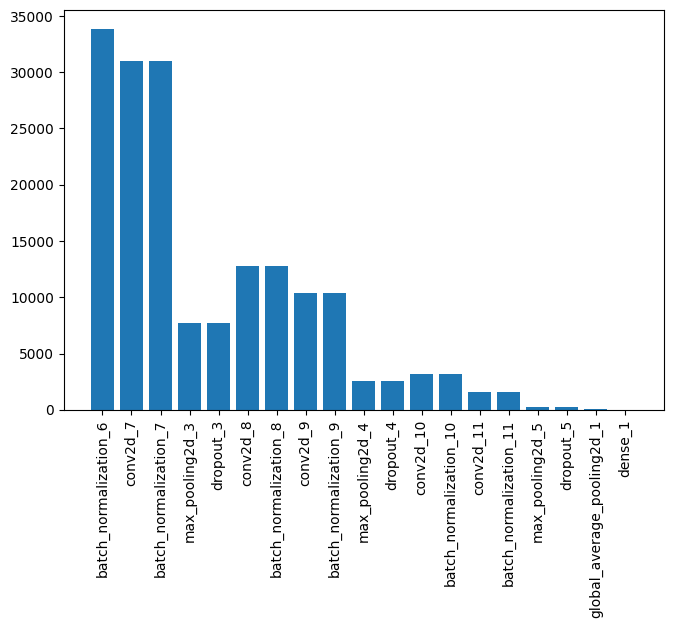

In [ ]:
#Evaluate the tensor size for the intermediate tensors (H*W*D)

fig = plt.figure(dpi=100)

ax = fig.add_axes([0,0,1,1])

l_idx   = []
l_sizes = []

for layer in model.layers[1:]:
  shape = layer.output_shape
  shape = np.delete(shape, 0)
  size  = np.prod(shape)
  l_idx   = np.append(l_idx, layer.name)
  l_sizes = np.append(l_sizes, size)

ax.bar(l_idx, l_sizes)
plt.xticks(rotation='vertical')
plt.show()

**IMPORTANT**

We can have a rough estimation of the tensor arena by adding the size of the biGgest tensor multiplied by 2 and the size of the input and output. For our case the biggest tensor has roughly 35k parameters which means that when quantized it will need 35k *8bit size = 35 KB(35*1024B), 70KB when multiplied. As for the input it will be 48*48*3 parameters of 8bit each. Thus the input will need 7KB(7*1024). We will also need 1B for the output. In reality tensor arena will need more space cause it needs to accomodate more parameters.

By our estimation it will need roughly 80KB

## Quantization aware training model and finetune it


#### Note that the resulting model is quantization aware but not quantized (e.g. the weights are float32 instead of int8). 


**THE MODEL ITSELF ISN'T QUANTIZED.THE MODEL LEARNS PARAMETERS THAT ARE MORE ROBUST TO QUANTIZATION.**

https://www.tensorflow.org/model_optimization/guide/quantization/training_example

https://blog.tensorflow.org/2020/04/quantization-aware-training-with-tensorflow-model-optimization-toolkit.html

#### quantize spacific type of layers

In [ ]:
# def apply_quantization_to_dense(layer):
#   if isinstance(layer, tf.keras.layers.Dense):
#     return tfmot.quantization.keras.quantize_annotate_layer(layer)
#   return layer

#quant dense

In [ ]:
# def apply_quantization_to_dense(layer):
#   if isinstance(layer, tf.keras.layers.Conv2D):
#     return tfmot.quantization.keras.quantize_annotate_layer(layer)
#   return layer

#quant conv

In [ ]:
def apply_quantization_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer


#quant conv and dense

In [ ]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_dense,
)

In [ ]:
annotated_model.build((None, hparams.dim3d[0],hparams.dim3d[1],hparams.dim3d[2]))

# Now that the Dense layers are annotated,
# `quantize_apply` actually makes the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

#### quantize everything

In [ ]:
# import tensorflow_model_optimization as tfmot

# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# quant_aware_model = quantize_model(model)

#### finetune and perform quant aware training

In [ ]:
quant_aware_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 48, 48, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d_6 (QuantizeWra  (None, 46, 46, 16)       483       
 pperV2)                                                         
                                                                 
 batch_normalization_6 (Batc  (None, 46, 46, 16)       64        
 hNormalization)                                                 
                                                                 
 quant_conv2d_7 (QuantizeWra  (None, 44, 44, 16)       2355      
 pperV2)                                                         
                                                                 
 batch_normalization_7 (Batc  (None, 44, 44, 16)      

In [ ]:
'''
Adding Callbacks and EarlyStopping
Callbacks and Checkpoints help to keep an eye on model while training and stop the training
if the performance has reached an optimum.
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'Callbacks/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', 
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max',
                             save_freq = "epoch", #check and save at the end of the epoch   
                             save_weights_only=False,   #save model too   
                             )#best accuracy saved

early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 7, #wait 7 epochs before you restore best weights and stop model trainng
                           mode="min", 
                           verbose = 1,
                           min_delta=0.01,
                           restore_best_weights=True)#go to the model that had the best accuracy before the early stopping before patience epochs

#https://keras.io/api/callbacks/model_checkpoint/
#https://keras.io/api/callbacks/early_stopping/


In [ ]:
#https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
#time decay
from tensorflow.keras.optimizers import Adam



def lr_time_based_decay(epoch, lr):
    initial_learning_rate = hparams.lr /100
    epochs = hparams.no_epochs
    decay = initial_learning_rate / (epochs) *1000

    return lr * 1 / (1 + decay * epoch)

time_decay_learning_rate = tf.keras.callbacks.LearningRateScheduler (lr_time_based_decay, verbose=1) #CALLBACK 
callbacks = [checkpoint, early_stop,time_decay_learning_rate]
optimizer = Adam(learning_rate=hparams.lr/100)

In [ ]:
# `quantize_model` requires a recompile.
quant_aware_model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
history = quant_aware_model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples // hparams.batch_size,
            validation_data = validation_generator, 
            validation_steps = validation_generator.samples // hparams.batch_size,
            epochs = 5,
            callbacks=[callbacks]
            )


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/5
97/97 [==============================] - ETA: 0s - loss: 0.7798 - accuracy: 0.7226
Epoch 1: val_accuracy improved from -inf to 0.74707, saving model to Callbacks/weights-improvement-01-0.75.hdf5
97/97 [==============================] - 55s 557ms/step - loss: 0.7798 - accuracy: 0.7226 - val_loss: 1.0060 - val_accuracy: 0.7471 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.998000147349282e-06.
Epoch 2/5
97/97 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.7738
Epoch 2: val_accuracy improved from 0.74707 to 0.83594, saving model to Callbacks/weights-improvement-02-0.84.hdf5
97/97 [==============================] - 53s 552ms/step - loss: 0.6498 - accuracy: 0.7738 - val_loss: 0.8223 - val_accuracy: 0.8359 - lr: 9.9980e-06

Epoch 3: LearningRateScheduler setting learning rate to 9.994002167662488e-06.
Epoch 3/5
97/97 [==============================] 

In [ ]:
quant_aware_model.evaluate(validation_generator, steps=validation_generator.samples // hparams.batch_size)

48/48 [==============================] - 15s 320ms/step - loss: 0.7392 - accuracy: 0.8590


[0.7392217516899109, 0.8590494990348816]

In [ ]:
quant_aware_model.evaluate(test_generator, steps=test_generator.samples // hparams.batch_size)

48/48 [==============================] - 15s 322ms/step - loss: 0.7282 - accuracy: 0.8613


[0.7282493710517883, 0.861328125]

In [ ]:
quant_aware_model.save("/content/drive/MyDrive/Portofolio/fruit_quant_aware/quant_saved_models/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Portofolio/fruit_quant_aware/quant_saved_models/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Portofolio/fruit_quant_aware/quant_saved_models/assets


In [ ]:
temp = tf.keras.models.load_model('quant_saved_models')

In [ ]:
temp.evaluate(validation_generator, steps=validation_generator.samples // hparams.batch_size)

48/48 [==============================] - 15s 314ms/step - loss: 0.7392 - accuracy: 0.8590


[0.7392217516899109, 0.8590494990348816]

In [ ]:
temp.evaluate(test_generator, steps=test_generator.samples // hparams.batch_size)

48/48 [==============================] - 15s 318ms/step - loss: 0.7283 - accuracy: 0.8607


[0.7283408045768738, 0.8606770634651184]

## SRAM MEMORY OF ARDUINO IS 256KB/0.25MB MODEL MUST FIT THERE

## Convert to TFLite

In [ ]:
# labels = glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*")
# labels = list(map(lambda x: x.split("/")[-1], labels))
# labels[:2]

In [ ]:
labels = list(train_generator.class_indices )
labels[:2]

['apple_6', 'apple_braeburn_1']

## Quantization Aware Model Full-Integer Quantization

In [ ]:
def representative_data_gen():

    imgs = tf.data.Dataset.from_tensor_slices(next(test_generator)[0]).batch(1)
    for i in imgs.take(64):#batch size
        i = tf.dtypes.cast(i, tf.float32)
        yield [i]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops=[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8 #quant only the input

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpwr0mq49h/assets


INFO:tensorflow:Assets written to: /tmp/tmpwr0mq49h/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


91304

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://archive.ubuntu.com/ubuntu bionic-upda

In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))
#print(len(tflite_model)/ float(2**20))

Header file in MB: 0.5370559692382812
TFLite Model in MB: 0.08707427978515625
TFLite Model in KB: 89.1640625


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]

def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  

  #leave input as it is
  i_value_s8 = i_value_f32

  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  # return (o_pred - o_zero_point) * o_scale
  return o_pred


In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)
print("number of test images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*")))

Pillow Version: 7.1.2
number of test images in total 6231


In [ ]:
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label

  # print(labels[np.argmax(pred)],label)
  # break
  if labels[np.argmax(pred)]==label:
    num_correct_samples = num_correct_samples + 1

  if ind%1000==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
1001 sample
2001 sample
3001 sample
4001 sample
5001 sample
6001 sample


0.8244262558176858

## Quantization Aware Model without quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5cebjz5l/assets


INFO:tensorflow:Assets written to: /tmp/tmp5cebjz5l/assets


617632

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 163 kB in 2s (97.7 kB/s)
Reading package lists... Don

In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))
#print(len(tflite_model)/ float(2**20))

Header file in MB: 3.632388114929199
TFLite Model in MB: 0.589019775390625
TFLite Model in KB: 603.15625


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]


def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  

  #leave input as it is
  i_value_s8 = i_value_f32

  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  # return (o_pred - o_zero_point) * o_scale
  return o_pred


In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.1.2


In [ ]:
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label

  # print(labels[np.argmax(pred)],label)
  # break
  if labels[np.argmax(pred)]==label:
    num_correct_samples = num_correct_samples + 1

  if ind%1000==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
1001 sample
2001 sample
3001 sample
4001 sample
5001 sample
6001 sample


0.8425613866153105


## Original model Full Integer Quantization

In [ ]:
def representative_data_gen():

    imgs = tf.data.Dataset.from_tensor_slices(next(test_generator)[0]).batch(1)
    for i in imgs.take(64):#batch size
        i = tf.dtypes.cast(i, tf.float32)
        yield [i]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpt5w54fc2/assets


INFO:tensorflow:Assets written to: /tmp/tmpt5w54fc2/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


90440

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 163 kB in 2s (96.6 kB/s)
Reading package lists... Don

In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))


Header file in MB: 0.5204753875732422
TFLite Model in MB: 0.08625030517578125
TFLite Model in KB: 88.3203125


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]



def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  

  #leave input as it is
  i_value_s8 = i_value_f32

  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  # return (o_pred - o_zero_point) * o_scale
  return o_pred


In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.1.2


In [ ]:
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label

  # print(labels[np.argmax(pred)],label)
  # break
  if labels[np.argmax(pred)]==label:
    num_correct_samples = num_correct_samples + 1

  if ind%1000==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
1001 sample
2001 sample
3001 sample
4001 sample
5001 sample
6001 sample


0.8332530893917509

## Original model without quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpy2z6qi_y/assets


INFO:tensorflow:Assets written to: /tmp/tmpy2z6qi_y/assets


304692

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 163 kB in 2s (95.5 kB/s)
Reading package lists... Don

In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))

Header file in MB: 1.7532472610473633
TFLite Model in MB: 0.2905769348144531
TFLite Model in KB: 297.55078125


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]


def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  
  #leave input as it is
  i_value_s8 = i_value_f32

  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  # return (o_pred - o_zero_point) * o_scale
  return o_pred

In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.1.2


In [ ]:
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label

  # print(labels[np.argmax(pred)],label)
  # break
  if labels[np.argmax(pred)]==label:
    num_correct_samples = num_correct_samples + 1

  if ind%1000==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
1001 sample
2001 sample
3001 sample
4001 sample
5001 sample
6001 sample


0.8351789439897288

## Quantization Aware Model Full Integer Quantization with Input Quantization too

In [ ]:
def representative_data_gen():

    imgs = tf.data.Dataset.from_tensor_slices(next(test_generator)[0]).batch(1)
    for i in imgs.take(64):#batch size
        i = tf.dtypes.cast(i, tf.float32)
        yield [i]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpga0xtvw7/assets


INFO:tensorflow:Assets written to: /tmp/tmpga0xtvw7/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


91008

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Fetched 163 kB in 2s (98.1 kB/s)
Reading package lists... Don

In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))

Header file in MB: 0.52374267578125
TFLite Model in MB: 0.0867919921875
TFLite Model in KB: 88.875


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]

i_quant = i_details["quantization_parameters"]
o_quant = o_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]



def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  
  # Quantize (float -> 8-bit) the input (check if input layer is 8-bit, first)
  i_value_f32 = i_value_f32 / i_scale + i_zero_point
  i_value_s8 = tf.cast(i_value_f32, dtype=tf.int8)


  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  return o_pred


In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.1.2


In [ ]:
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label

  # print(labels[np.argmax(pred)],label)
  # break
  if labels[np.argmax(pred)]==label:
    num_correct_samples = num_correct_samples + 1

  if ind%1000==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
1001 sample
2001 sample
3001 sample
4001 sample
5001 sample
6001 sample


0.8194511314395763

## Original Model Full Integer Quantization with Input Quantization too

In [ ]:
def representative_data_gen():

    imgs = tf.data.Dataset.from_tensor_slices(next(test_generator)[0]).batch(1)
    for i in imgs.take(64):#batch size
        i = tf.dtypes.cast(i, tf.float32)
        yield [i]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp5cgw7coi/assets


INFO:tensorflow:Assets written to: /tmp/tmp5cgw7coi/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


90256

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 163 kB in 2s (94.6 kB/s)
Reading package lists... Don

In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))
#print(len(tflite_model)/ float(2**20))

Header file in MB: 0.5194168090820312
TFLite Model in MB: 0.0860748291015625
TFLite Model in KB: 88.140625


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]

i_quant = i_details["quantization_parameters"]
o_quant = o_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]



def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  
  # Quantize (float -> 8-bit) the input (check if input layer is 8-bit, first)
  i_value_f32 = i_value_f32 / i_scale + i_zero_point
  i_value_s8 = tf.cast(i_value_f32, dtype=tf.int8)



  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  return o_pred


In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)

Pillow Version: 7.1.2
number of test images in total 200


In [ ]:
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fruit_quant_aware/Training/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label

  # print(labels[np.argmax(pred)],label)
  # break
  if labels[np.argmax(pred)]==label:
    num_correct_samples = num_correct_samples + 1

  if ind%1000==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
1001 sample
2001 sample
3001 sample
4001 sample
5001 sample
6001 sample


0.8478574867597496

## create an image as example

In [ ]:
import sys
import numpy
np.set_printoptions(threshold=sys.maxsize)

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  
  label = (img_path.split("/")[-2])#contains the true label
  print(label)
  break

image.flatten()

fire


array([ 18,  12,  12,  20,  14,  14,  20,  14,  14,  25,  16,  15,  26,
        16,  15,  23,  13,  12,  17,   7,   6,  18,   8,   7,  20,  10,
         9,  21,  11,  10,  21,   8,   8,  25,  10,  10,  24,  11,   6,
        23,   9,   7,  23,   9,   9,  22,   8,   8,  23,   9,   9,  20,
         7,   7,  14,   2,   4,  15,   3,   5,  16,   4,   5,  15,   3,
         3,  15,   4,   3,  19,   3,   6,  21,   3,   8,  25,   5,   7,
        36,   4,   8,  35,   9,   8,  41,  15,   6,  43,  18,   9,  31,
         8,   3,  35,   7,   2,  46,  15,   9,  49,  15,   6,  45,  17,
         9,  36,  15,  14,  34,  11,   8,  33,  13,   4,  29,  10,   4,
        20,   4,   1,  14,   2,   1,  15,   3,   2,  27,  11,   5,  32,
        11,   7,  35,  13,   6,  28,   9,   3,  19,   6,   5,  14,   3,
         4,  19,  13,  13,  24,  18,  18,  17,  11,  10,  27,  17,  15,
        28,  18,  16,  22,  12,  10,  19,   9,   6,  20,  10,   7,  22,
        12,   9,  21,  11,   9,  22,  10,   8,  26,  11,   9,  2